In [1]:
print("Setting up environment...")
!git clone https://github.com/perrying/guided-filter-pytorch.git
import sys
sys.path.append('/kaggle/working/guided-filter-pytorch')

Setting up environment...
Cloning into 'guided-filter-pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 6), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 3.80 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from guided_filter import GuidedFilter2d

### DataPrep

In [3]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)

        return image, (mask > 0.5).long()

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [5]:
BATCH_SIZE = 4
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
def get_norm_layer(norm_type='batch'):
    return nn.BatchNorm2d if norm_type == 'batch' else None

def init_net(net, init_type='xavier', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

### Loss

In [7]:
class DeepCrackLossBCE(nn.Module):
    def __init__(self):
        super(DeepCrackLossBCE, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.bce_loss(output, targets.float()) for i, output in enumerate(outputs[:-1]))
        total_loss += self.bce_loss(outputs[-1], targets.float())
        return total_loss

In [8]:
class DeepCrackLossWeightedBCE(nn.Module):
    def __init__(self, weight_pos=1.0, weight_neg=1.0):
        super(DeepCrackLossWeightedBCE, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        weights = torch.where(targets > 0, self.weight_pos, self.weight_neg).to(targets.device)
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * (self.bce_loss(output, targets.float()) * weights).mean() for i, output in enumerate(outputs[:-1]))
        total_loss += (self.bce_loss(outputs[-1], targets.float()) * weights).mean()
        return total_loss

def calculate_class_weights(dataloader):
    total_pixels = 0
    total_pos = 0
    print("Calculating class weights for Weighted BCE...")
    for _, labels in tqdm(dataloader):
        total_pixels += labels.numel()
        total_pos += labels.sum().item()
    weight_pos = total_pixels / (2 * total_pos)
    weight_neg = total_pixels / (2 * (total_pixels - total_pos))
    print(f"Weight for Positive (crack): {weight_pos:.4f}, Weight for Negative (non-crack): {weight_neg:.4f}")
    return weight_pos, weight_neg

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha; self.gamma = gamma
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        return (self.alpha * (1 - pt) ** self.gamma * bce_loss).mean()

class DeepCrackLossFocal(nn.Module):
    def __init__(self):
        super(DeepCrackLossFocal, self).__init__()
        self.focal_loss = FocalLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.focal_loss(output, targets) for i, output in enumerate(outputs[:-1]))
        total_loss += self.focal_loss(outputs[-1], targets)
        return total_loss
        
print("Loss functions defined.")

Loss functions defined.


### VGG

In [10]:
class DeepCrackNet_VGG(nn.Module):
    def __init__(self, in_nc=3, num_classes=1, ngf=64):
        super(DeepCrackNet_VGG, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        # SỬA LỖI: Định nghĩa các block convolution một cách tường minh và tuần tự
        self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, 2))
        self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, 2))
        self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, 3))
        self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, 3))
        self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, 3))

        self.side_conv1 = nn.Conv2d(ngf, num_classes, 1)
        self.side_conv2 = nn.Conv2d(ngf*2, num_classes, 1)
        self.side_conv3 = nn.Conv2d(ngf*4, num_classes, 1)
        self.side_conv4 = nn.Conv2d(ngf*8, num_classes, 1)
        self.side_conv5 = nn.Conv2d(ngf*8, num_classes, 1)

        # Logic upsampling rõ ràng hơn
        self.deconv2 = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(num_classes, num_classes, 8, 4, 2)
        self.deconv4 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4)
        self.deconv5 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4) # conv5 cùng size conv4

        self.fuse_conv = nn.Conv2d(num_classes*5, num_classes, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    # SỬA LỖI: Hàm _conv_block được viết lại cho rõ ràng và chính xác
    def _conv_block(self, in_channels, out_channels, norm_layer, num_convs):
        layers = []
        current_in_channels = in_channels
        for _ in range(num_convs):
            layers.append(nn.Conv2d(current_in_channels, out_channels, kernel_size=3, padding=1, bias=False))
            layers.append(norm_layer(out_channels))
            layers.append(nn.ReLU(True))
            current_in_channels = out_channels # Cập nhật kênh đầu vào cho lớp conv tiếp theo trong block
        return layers

    def forward(self, x):
        # Encoder
        f1 = self.conv1(x)
        f2 = self.conv2(self.maxpool(f1))
        f3 = self.conv3(self.maxpool(f2))
        f4 = self.conv4(self.maxpool(f3))
        f5 = self.conv5(f4) # Không maxpool sau block này

        # Side-outputs và Upsampling
        s1 = self.side_conv1(f1)
        s2 = self.deconv2(self.side_conv2(f2))
        s3 = self.deconv3(self.side_conv3(f3))
        s4 = self.deconv4(self.side_conv4(f4))
        s5 = self.deconv5(self.side_conv5(f5))
        
        side_outputs = [s1, s2, s3, s4, s5]
        
        # Fuse và Guided Filter
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        guided_fused = self.guided_filter(s1, fused) # s1 làm guidance, fused làm input

        if self.training:
            return side_outputs + [guided_fused]
        return torch.sigmoid(guided_fused)

### Train

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="[Val]"):
                outputs = model(images.to(device))
                pred = (outputs > 0.5).float()
                intersection = (pred * labels.to(device)).sum()
                union = pred.sum() + labels.to(device).sum() - intersection
                total_iou += (intersection + 1e-6) / (union + 1e-6)
        
        avg_iou = total_iou / len(val_loader)
        history['val_iou'].append(avg_iou.item())
        print(f"Epoch {epoch+1} | Train Loss: {history['train_loss'][-1]:.4f} | Val IoU: {avg_iou:.4f}")
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), 'vgg_best_model.pth')
            print(f"  -> New best model saved with IoU: {best_iou:.4f}")
            
    model.load_state_dict(torch.load('vgg_best_model.pth'))
    return model, history

In [12]:
def visualize(model, loader, device, title):
    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        outputs = model(images.to(device))
        pred = (outputs > 0.5).float()

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)
        for i in range(min(3, len(images))):
            plt.subplot(1, 3, 1)
            plt.imshow(inv_norm(images[i]).permute(1, 2, 0).clamp(0, 1)); plt.title('Input'); plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(labels[i].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
            plt.show()
            break # Show one example

print("Training and visualization functions ready.")

Training and visualization functions ready.


Using device: cuda
Calculating class weights for Weighted BCE...


100%|██████████| 375/375 [00:12<00:00, 30.65it/s]


Weight for Positive (crack): 17.3183, Weight for Negative (non-crack): 0.5149

STARTING: VGG-Style with BCE Loss


[Val]: 100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


Epoch 1 | Train Loss: 2.0345 | Val IoU: 0.2769
  -> New best model saved with IoU: 0.2769


[Val]: 100%|██████████| 100/100 [00:04<00:00, 24.12it/s]


Epoch 2 | Train Loss: 0.8560 | Val IoU: 0.2627


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 3 | Train Loss: 0.5022 | Val IoU: 0.2143


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.94it/s]


Epoch 4 | Train Loss: 0.3772 | Val IoU: 0.2498


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


Epoch 5 | Train Loss: 0.3298 | Val IoU: 0.2060


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


Epoch 6 | Train Loss: 0.2972 | Val IoU: 0.2470


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.07it/s]


Epoch 7 | Train Loss: 0.2737 | Val IoU: 0.2824
  -> New best model saved with IoU: 0.2824


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.35it/s]


Epoch 8 | Train Loss: 0.2594 | Val IoU: 0.3167
  -> New best model saved with IoU: 0.3167


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


Epoch 9 | Train Loss: 0.2562 | Val IoU: 0.3075


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.04it/s]


Epoch 10 | Train Loss: 0.2426 | Val IoU: 0.3212
  -> New best model saved with IoU: 0.3212


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.03it/s]


Epoch 11 | Train Loss: 0.2365 | Val IoU: 0.3370
  -> New best model saved with IoU: 0.3370


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.97it/s]


Epoch 12 | Train Loss: 0.2310 | Val IoU: 0.3171


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.19it/s]


Epoch 13 | Train Loss: 0.2279 | Val IoU: 0.3337


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.07it/s]


Epoch 14 | Train Loss: 0.2224 | Val IoU: 0.3517
  -> New best model saved with IoU: 0.3517


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.89it/s]


Epoch 15 | Train Loss: 0.2190 | Val IoU: 0.3489


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.92it/s]


Epoch 16 | Train Loss: 0.2195 | Val IoU: 0.3444


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


Epoch 17 | Train Loss: 0.2169 | Val IoU: 0.3380


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.92it/s]


Epoch 18 | Train Loss: 0.2118 | Val IoU: 0.3409


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 19 | Train Loss: 0.2102 | Val IoU: 0.3619
  -> New best model saved with IoU: 0.3619


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.73it/s]


Epoch 20 | Train Loss: 0.2125 | Val IoU: 0.3493


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.92it/s]


Epoch 21 | Train Loss: 0.2086 | Val IoU: 0.3692
  -> New best model saved with IoU: 0.3692


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


Epoch 22 | Train Loss: 0.2047 | Val IoU: 0.3752
  -> New best model saved with IoU: 0.3752


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


Epoch 23 | Train Loss: 0.2057 | Val IoU: 0.3484


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]


Epoch 24 | Train Loss: 0.2049 | Val IoU: 0.3546


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


Epoch 25 | Train Loss: 0.2025 | Val IoU: 0.3637


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 26 | Train Loss: 0.2024 | Val IoU: 0.3243


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 27 | Train Loss: 0.2004 | Val IoU: 0.3444


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.86it/s]


Epoch 28 | Train Loss: 0.1973 | Val IoU: 0.3744


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


Epoch 29 | Train Loss: 0.1980 | Val IoU: 0.3877
  -> New best model saved with IoU: 0.3877


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


Epoch 30 | Train Loss: 0.1990 | Val IoU: 0.3418


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]


Epoch 31 | Train Loss: 0.1997 | Val IoU: 0.3563


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 32 | Train Loss: 0.1924 | Val IoU: 0.3577


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 33 | Train Loss: 0.1950 | Val IoU: 0.3514


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.93it/s]


Epoch 34 | Train Loss: 0.1930 | Val IoU: 0.3595


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 35 | Train Loss: 0.1922 | Val IoU: 0.3643


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 36 | Train Loss: 0.1904 | Val IoU: 0.3567


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 37 | Train Loss: 0.1891 | Val IoU: 0.3676


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 38 | Train Loss: 0.1863 | Val IoU: 0.3804


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.51it/s]


Epoch 39 | Train Loss: 0.1860 | Val IoU: 0.3691


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 40 | Train Loss: 0.1899 | Val IoU: 0.3727


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 41 | Train Loss: 0.1866 | Val IoU: 0.3791


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 42 | Train Loss: 0.1862 | Val IoU: 0.3722


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.71it/s]


Epoch 43 | Train Loss: 0.1864 | Val IoU: 0.3744


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.37it/s]


Epoch 44 | Train Loss: 0.1840 | Val IoU: 0.3486


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


Epoch 45 | Train Loss: 0.1810 | Val IoU: 0.3686


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 46 | Train Loss: 0.1816 | Val IoU: 0.3643


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


Epoch 47 | Train Loss: 0.1847 | Val IoU: 0.3836


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 48 | Train Loss: 0.1823 | Val IoU: 0.3795


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 49 | Train Loss: 0.1800 | Val IoU: 0.3676


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 50 | Train Loss: 0.1768 | Val IoU: 0.3708


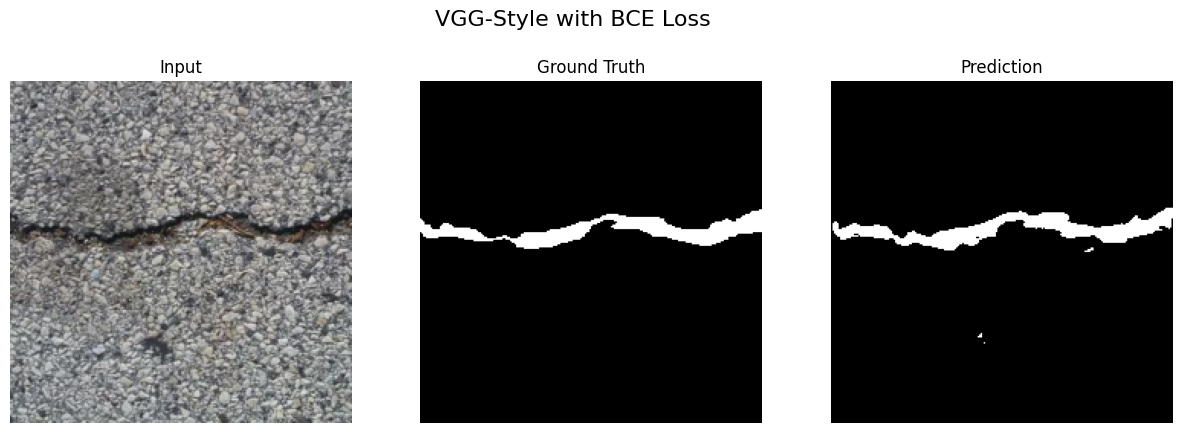


STARTING: VGG-Style with Weighted BCE Loss


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


Epoch 1 | Train Loss: 2.0903 | Val IoU: 0.1070
  -> New best model saved with IoU: 0.1070


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 2 | Train Loss: 1.4689 | Val IoU: 0.1225
  -> New best model saved with IoU: 0.1225


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 3 | Train Loss: 1.2201 | Val IoU: 0.1379
  -> New best model saved with IoU: 0.1379


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.86it/s]


Epoch 4 | Train Loss: 1.0772 | Val IoU: 0.1407
  -> New best model saved with IoU: 0.1407


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]


Epoch 5 | Train Loss: 1.0326 | Val IoU: 0.1265


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


Epoch 6 | Train Loss: 0.9797 | Val IoU: 0.1533
  -> New best model saved with IoU: 0.1533


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 7 | Train Loss: 0.9595 | Val IoU: 0.1479


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 8 | Train Loss: 0.9049 | Val IoU: 0.1496


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


Epoch 9 | Train Loss: 0.9160 | Val IoU: 0.1323


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 10 | Train Loss: 0.8919 | Val IoU: 0.1553
  -> New best model saved with IoU: 0.1553


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


Epoch 11 | Train Loss: 0.8701 | Val IoU: 0.1407


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


Epoch 12 | Train Loss: 0.8724 | Val IoU: 0.1529


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


Epoch 13 | Train Loss: 0.8607 | Val IoU: 0.1530


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.34it/s]


Epoch 14 | Train Loss: 0.8217 | Val IoU: 0.1969
  -> New best model saved with IoU: 0.1969


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 15 | Train Loss: 0.8256 | Val IoU: 0.1735


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.52it/s]


Epoch 16 | Train Loss: 0.8277 | Val IoU: 0.1791


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


Epoch 17 | Train Loss: 0.8104 | Val IoU: 0.1519


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.66it/s]


Epoch 18 | Train Loss: 0.8040 | Val IoU: 0.1751


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 19 | Train Loss: 0.7887 | Val IoU: 0.1752


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 20 | Train Loss: 0.7682 | Val IoU: 0.1651


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


Epoch 21 | Train Loss: 0.8055 | Val IoU: 0.1579


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 22 | Train Loss: 0.7674 | Val IoU: 0.1693


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 23 | Train Loss: 0.7592 | Val IoU: 0.1541


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


Epoch 24 | Train Loss: 0.7547 | Val IoU: 0.1727


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


Epoch 25 | Train Loss: 0.7577 | Val IoU: 0.2319
  -> New best model saved with IoU: 0.2319


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 26 | Train Loss: 0.7367 | Val IoU: 0.1672


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.56it/s]


Epoch 27 | Train Loss: 0.7700 | Val IoU: 0.2079


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 28 | Train Loss: 0.7431 | Val IoU: 0.1506


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


Epoch 29 | Train Loss: 0.7182 | Val IoU: 0.1554


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.55it/s]


Epoch 30 | Train Loss: 0.7292 | Val IoU: 0.1900


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


Epoch 31 | Train Loss: 0.7469 | Val IoU: 0.1840


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.49it/s]


Epoch 32 | Train Loss: 0.7122 | Val IoU: 0.1837


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 33 | Train Loss: 0.7168 | Val IoU: 0.2262


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 34 | Train Loss: 0.7021 | Val IoU: 0.1745


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 35 | Train Loss: 0.7145 | Val IoU: 0.1602


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 36 | Train Loss: 0.7070 | Val IoU: 0.1776


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.41it/s]


Epoch 37 | Train Loss: 0.6860 | Val IoU: 0.1723


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.47it/s]


Epoch 38 | Train Loss: 0.6838 | Val IoU: 0.1504


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


Epoch 39 | Train Loss: 0.6896 | Val IoU: 0.1924


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 40 | Train Loss: 0.6767 | Val IoU: 0.1693


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 41 | Train Loss: 0.6752 | Val IoU: 0.1884


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


Epoch 42 | Train Loss: 0.6697 | Val IoU: 0.1606


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 43 | Train Loss: 0.6599 | Val IoU: 0.1560


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 44 | Train Loss: 0.7143 | Val IoU: 0.1823


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 45 | Train Loss: 0.6459 | Val IoU: 0.2573
  -> New best model saved with IoU: 0.2573


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


Epoch 46 | Train Loss: 0.6910 | Val IoU: 0.1927


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 47 | Train Loss: 0.6507 | Val IoU: 0.1580


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.46it/s]


Epoch 48 | Train Loss: 0.6580 | Val IoU: 0.2006


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 49 | Train Loss: 0.6472 | Val IoU: 0.2035


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.61it/s]


Epoch 50 | Train Loss: 0.6446 | Val IoU: 0.2124


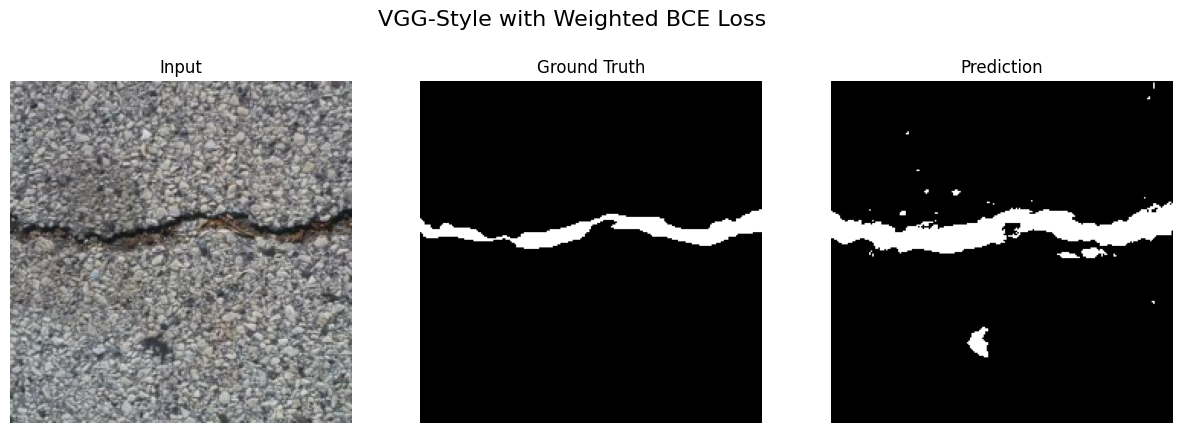


STARTING: VGG-Style with Focal Loss


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


Epoch 1 | Train Loss: 0.3241 | Val IoU: 0.2891
  -> New best model saved with IoU: 0.2891


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.13it/s]


Epoch 2 | Train Loss: 0.1359 | Val IoU: 0.2910
  -> New best model saved with IoU: 0.2910


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Epoch 3 | Train Loss: 0.0883 | Val IoU: 0.2204


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


Epoch 4 | Train Loss: 0.0649 | Val IoU: 0.3056
  -> New best model saved with IoU: 0.3056


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 5 | Train Loss: 0.0564 | Val IoU: 0.3304
  -> New best model saved with IoU: 0.3304


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


Epoch 6 | Train Loss: 0.0523 | Val IoU: 0.3275


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.56it/s]


Epoch 7 | Train Loss: 0.0512 | Val IoU: 0.3480
  -> New best model saved with IoU: 0.3480


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.98it/s]


Epoch 8 | Train Loss: 0.0488 | Val IoU: 0.3220


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


Epoch 9 | Train Loss: 0.0473 | Val IoU: 0.3486
  -> New best model saved with IoU: 0.3486


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 10 | Train Loss: 0.0461 | Val IoU: 0.3575
  -> New best model saved with IoU: 0.3575


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.73it/s]


Epoch 11 | Train Loss: 0.0458 | Val IoU: 0.3691
  -> New best model saved with IoU: 0.3691


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 12 | Train Loss: 0.0462 | Val IoU: 0.3402


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


Epoch 13 | Train Loss: 0.0444 | Val IoU: 0.3221


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 14 | Train Loss: 0.0438 | Val IoU: 0.3412


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


Epoch 15 | Train Loss: 0.0436 | Val IoU: 0.3564


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.40it/s]


Epoch 16 | Train Loss: 0.0427 | Val IoU: 0.3721
  -> New best model saved with IoU: 0.3721


[Val]: 100%|██████████| 100/100 [00:04<00:00, 23.00it/s]


Epoch 17 | Train Loss: 0.0429 | Val IoU: 0.3553


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 18 | Train Loss: 0.0428 | Val IoU: 0.3576


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


Epoch 19 | Train Loss: 0.0420 | Val IoU: 0.3526


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 20 | Train Loss: 0.0420 | Val IoU: 0.3610


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


Epoch 21 | Train Loss: 0.0411 | Val IoU: 0.3590


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 22 | Train Loss: 0.0410 | Val IoU: 0.3755
  -> New best model saved with IoU: 0.3755


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.11it/s]


Epoch 23 | Train Loss: 0.0409 | Val IoU: 0.3757
  -> New best model saved with IoU: 0.3757


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 24 | Train Loss: 0.0412 | Val IoU: 0.3623


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


Epoch 25 | Train Loss: 0.0403 | Val IoU: 0.3737


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.66it/s]


Epoch 26 | Train Loss: 0.0399 | Val IoU: 0.3724


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 27 | Train Loss: 0.0396 | Val IoU: 0.3552


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 28 | Train Loss: 0.0397 | Val IoU: 0.3701


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.72it/s]


Epoch 29 | Train Loss: 0.0394 | Val IoU: 0.3610


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


Epoch 30 | Train Loss: 0.0384 | Val IoU: 0.3542


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.88it/s]


Epoch 31 | Train Loss: 0.0397 | Val IoU: 0.3667


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.49it/s]


Epoch 32 | Train Loss: 0.0388 | Val IoU: 0.3635


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.49it/s]


Epoch 33 | Train Loss: 0.0383 | Val IoU: 0.3577


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


Epoch 34 | Train Loss: 0.0396 | Val IoU: 0.3637


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.04it/s]


Epoch 35 | Train Loss: 0.0377 | Val IoU: 0.3883
  -> New best model saved with IoU: 0.3883


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


Epoch 36 | Train Loss: 0.0372 | Val IoU: 0.3755


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 37 | Train Loss: 0.0371 | Val IoU: 0.3649


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 38 | Train Loss: 0.0374 | Val IoU: 0.3987
  -> New best model saved with IoU: 0.3987


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.46it/s]


Epoch 39 | Train Loss: 0.0369 | Val IoU: 0.3688


[Val]: 100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


Epoch 40 | Train Loss: 0.0368 | Val IoU: 0.3695


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 41 | Train Loss: 0.0387 | Val IoU: 0.3653


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 42 | Train Loss: 0.0364 | Val IoU: 0.3755


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.74it/s]


Epoch 43 | Train Loss: 0.0367 | Val IoU: 0.3918


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 44 | Train Loss: 0.0364 | Val IoU: 0.3870


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Epoch 45 | Train Loss: 0.0360 | Val IoU: 0.3663


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


Epoch 46 | Train Loss: 0.0365 | Val IoU: 0.3888


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


Epoch 47 | Train Loss: 0.0354 | Val IoU: 0.3867


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


Epoch 48 | Train Loss: 0.0355 | Val IoU: 0.3806


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 49 | Train Loss: 0.0356 | Val IoU: 0.3790


[Val]: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


Epoch 50 | Train Loss: 0.0360 | Val IoU: 0.3921


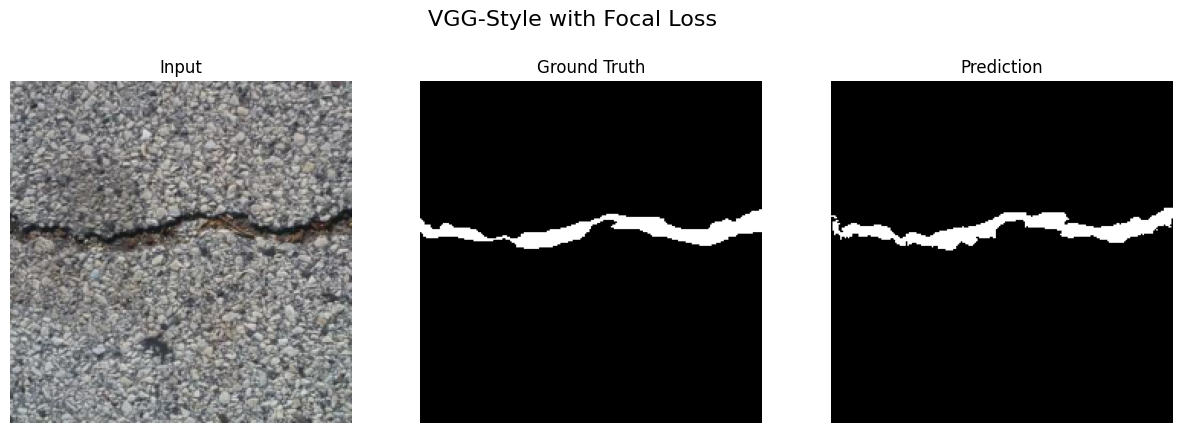

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_EPOCHS = 50
LEARNING_RATE = 0.0001

w_pos, w_neg = calculate_class_weights(train_loader)
loss_functions = {
    'BCE Loss': DeepCrackLossBCE(),
    'Weighted BCE Loss': DeepCrackLossWeightedBCE(weight_pos=w_pos, weight_neg=w_neg),
    'Focal Loss': DeepCrackLossFocal()
}

vgg_histories = {}
for loss_name, loss_fn in loss_functions.items():
    experiment_name = f"VGG-Style with {loss_name}"
    print(f"\n{'='*20}\nSTARTING: {experiment_name}\n{'='*20}")
    
    model = DeepCrackNet_VGG()
    model = init_net(model, gpu_ids=[0] if torch.cuda.is_available() else [])
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    model, history = train(model, train_loader, val_loader, loss_fn.to(device), optimizer, NUM_EPOCHS, device)
    vgg_histories[loss_name] = history
    
    visualize(model, val_loader, device, title=experiment_name)

Plotting comparison graphs for VGG-Style Backbone...


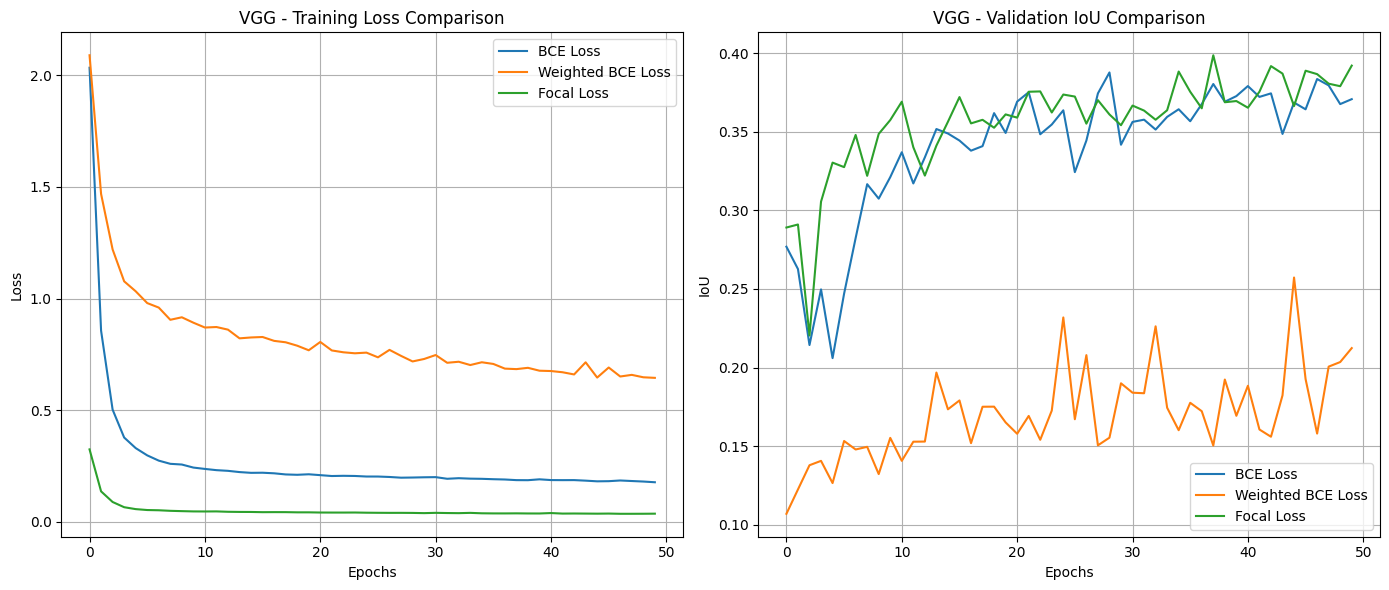

In [14]:
print("Plotting comparison graphs for VGG-Style Backbone...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in vgg_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('VGG - Training Loss Comparison')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in vgg_histories.items():
    plt.plot(history['val_iou'], label=name)
plt.title('VGG - Validation IoU Comparison')
plt.xlabel('Epochs'); plt.ylabel('IoU'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()